### Objective

Covert Time range into 04:00-04:00


In [263]:
import numpy as np

import os ,sys

import random

import matplotlib.pyplot as plt

import pandas as pd

import copy


from matplotlib.ticker import MultipleLocator, FormatStrFormatter

In [208]:
Save_Path='./Data/Estimation/'

Labels=['A','B','C']

Multinomial=np.load(os.path.join(Save_Path,'Multinomial.npy')).item()

Param_A=np.load(os.path.join(Save_Path,'Param_A.npy')).item()

Param_B=np.load(os.path.join(Save_Path,'Param_B.npy')).item()

Param_C=np.load(os.path.join(Save_Path,'Param_C.npy')).item()

Duration=np.load(os.path.join(Save_Path,'Duration.npy')).item()

GAP=np.load(os.path.join(Save_Path,'GAP.npy')).item()




In [209]:
count1 = 18919;
count2 = 5120;
count3 = 13457;



In [210]:
'''Shifts quantity'''

def Random_pick(distribution,num,cluster):
    
    dic=distribution[cluster]
    
    return np.array([np.random.choice(list(dic.keys()),p=list(dic.values())) for i in range(num)])

shiftNum1=Random_pick(Multinomial,count1,'A')

shiftNum2=Random_pick(Multinomial,count2,'B')

shiftNum3=Random_pick(Multinomial,count3,'C')

In [211]:
Param_A

{'min': 0.26666666666666666,
 'max': 11.616666666666667,
 'mu1': -7.072995085515873,
 'sigma1': 2.8335027403267823,
 'A1': 35.983398984378766,
 'mu2': 7.495514018659986,
 'sigma2': 0.36987439459821553,
 'A2': 0.12375629874924435,
 'mu3': 9.166225464383238,
 'sigma3': 0.8234393350436715,
 'A3': 0.18110385835586465,
 'mu4': 10.08533042934507,
 'sigma4': 2.478004465425975,
 'A4': 0.565487098121409}

In [217]:
'''First Shift Start Hour'''

class Sampling(object):
    
    def __init__(self,Param):
        
        self.modal=int((len(Param)-2)/3)
        
        self.mu=list()
        
        self.sigma=list()
        
        self.A=list()
        
        for i in range(self.modal):
            
            self.mu.append(Param['mu'+str(i+1)])
            
            self.sigma.append(Param['sigma'+str(i+1)])
            
            self.A.append(Param['A'+str(i+1)])
            
        self.min_=round(Param['min'],2)
        self.max_=round(Param['max'],2)+0.01

    def gauss(self,x,mu,sigma,A):
        
        return A*np.exp(-(x-mu)**2/2/sigma**2)*(1/np.sqrt(2*np.pi)/sigma)
    
    def Multi_Modal(self,x):
        
        num=0
        
        for i in range(self.modal):
            
            num+=self.gauss(x,self.mu[i],self.sigma[i],self.A[i])
            
        return num

    
    def discrete_sampler(self,quantity):
        
        Samples_dic={}
        
        for x in np.arange(self.min_,self.max_,0.01):

            r=self.Multi_Modal(x)

            Samples_dic[x]=r
            
        Norm=sum(Samples_dic.values())

        Samples_dic={k:v/Norm for k,v in Samples_dic.items()}
        
        arr=[np.random.choice(list(Samples_dic.keys()),p=list(Samples_dic.values())) for i in range(quantity)]
        
        return arr

Samp=Sampling(Param_A)

First_Shift_Start_Hour_1=Samp.discrete_sampler(count1)

Samp=Sampling(Param_B)

First_Shift_Start_Hour_2=Samp.discrete_sampler(count2)

Samp=Sampling(Param_C)

First_Shift_Start_Hour_3=Samp.discrete_sampler(count3)

In [219]:
'''Shift'''

def Truncted_sampler(shape,scale,min_,max_):
    
    num=np.random.normal(shape, scale,1)[0]
    
    while num <min_+0.1 or num>max_:
        
        num=np.random.normal(shape, scale,1)[0]
        
    return num
        
Shifts={'A':{i:{'Start':[First_Shift_Start_Hour_1[i]],'End':[]} for i in range(count1)},\
        'B':{j:{'Start':[First_Shift_Start_Hour_2[j]],'End':[]} for j in range(count2)},\
        'C':{k:{'Start':[First_Shift_Start_Hour_3[k]],'End':[]} for k in range(count3)}}

Shifts_Num={'A':{i:shiftNum1[i] for i in range(count1)},\
            'B':{j:shiftNum1[j] for j in range(count2)},\
            'C':{k:shiftNum1[k] for k in range(count3)}}


for cluster,shifts in Shifts.items():
    
    for driver_id in shifts.keys():
        
        shift_num=Shifts_Num[cluster][driver_id]
        
        while True:
                 
            Start_hour=int(Shifts[cluster][driver_id]['Start'][-1])
            
            duration=Truncted_sampler(Duration[cluster][Start_hour]['mean'],\
                                      Duration[cluster][Start_hour]['std'],\
                                      Duration[cluster][Start_hour]['min'],\
                                      Duration[cluster][Start_hour]['max'])
            
            if Shifts[cluster][driver_id]['Start'][-1]+duration>23.9:
                
                duration=23.9-Start_hour
            
                Shifts[cluster][driver_id]['End'].append(Shifts[cluster][driver_id]['Start'][-1]+duration)
                
                break
                
            else:
                
                Shifts[cluster][driver_id]['End'].append(Shifts[cluster][driver_id]['Start'][-1]+duration)
                
                if len(Shifts[cluster][driver_id]['End'])==shift_num:
                    
                    break
                
                End_hour=int(Shifts[cluster][driver_id]['End'][-1])
                
                
                if End_hour<22:
                
                    gap=Truncted_sampler(GAP[cluster][End_hour]['mean'],\
                                         GAP[cluster][End_hour]['std'],\
                                         GAP[cluster][End_hour]['min'],\
                                         GAP[cluster][End_hour]['max'])
                    
                else:
                    
                    gap=2
                     

                if Shifts[cluster][driver_id]['End'][-1]+gap>23.9:
                    
                    break
                    
                else:
                
                    Shifts[cluster][driver_id]['Start'].append(Shifts[cluster][driver_id]['End'][-1]+gap)
                    

In [220]:
def explode(df, col):
    df[col] = df[col].apply(lambda x: [x] if not isinstance(x, list) else x)
    return df.drop(col, axis=1).join(
        pd.DataFrame(list(df[col])).stack().reset_index(level=1, drop=True).rename(col)
    ) 


Pred_df=pd.DataFrame([],columns=['Start','End'])

for cluster in ['A','B','C']:

    df=pd.DataFrame(Shifts[cluster].values())
    
    df=df[['Start','End']]
    
    Pred_df=pd.concat([Pred_df,df],ignore_index=True)
    
Pred_df=Pred_df[['Start','End']]

Pred_df['Transition']=Pred_df.apply(lambda x: [(x['Start'][i],x['End'][i]) for i in range(len(x['Start']))],axis=1)

Pred_df=Pred_df[['Transition']]

Pred_df=explode(Pred_df,'Transition')

Pred_df['Start']=Pred_df.apply(lambda x:round(x['Transition'][0],1),axis=1)

Pred_df['End']=Pred_df.apply(lambda x:round(x['Transition'][1],1),axis=1)

Pred_df['Active_range']=Pred_df.apply(lambda x:[round(y,1) for y in np.arange(x['Start'],x['End']+0.1,0.1)],axis=1)

Pred_df=Pred_df[['Active_range','Start']]

Pred_df=explode(Pred_df,'Active_range')

Pred_df=Pred_df.rename(columns={'Active_range':'step'})

Pred_df=Pred_df.groupby('step').count()

Pred_df['step']=Pred_df.index

Pred_df=Pred_df.rename(columns={'Start':'Count'})

Pred_df=Pred_df[['step','Count']]

Pred_df=Pred_df.reset_index(drop=True)

Pred_df=Pred_df.sort_values(by='step')

Pred_df=Pred_df.reset_index(drop=True)


,step,Count
0,0.3,472
1,0.4,977
2,0.5,1435
3,0.6,1865
4,0.7,2181
5,0.8,2464
6,0.9,2710
7,1.0,2893
8,1.1,3150
9,1.2,3324


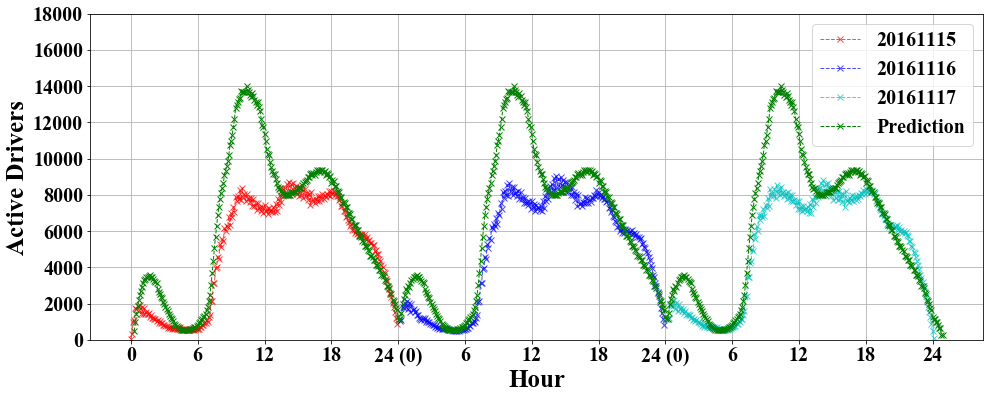

In [268]:
Test_path='./Data/Test/'

'''Loading Validation'''


Validation=pd.DataFrame([],columns=['step','Count','date'])

Prediction=pd.DataFrame([],columns=['step','Count'])

dts=['20161115','20161116','20161117']

colors=['r','b','c']

for i in range(len(dts)):

    Val=pd.read_csv(os.path.join(Test_path,'Validation_'+dts[i]+'.csv'))
    
    Val=Val[['step','Count']]
    
    Val['date']=dts[i]
    
    Val['step']=Val.apply(lambda x:x['step']+i*24,axis=1)
    
    Validation=pd.concat([Validation,Val],ignore_index=True)
    
    P_df=copy.deepcopy(Pred_df)
    
    P_df['step']=P_df.apply(lambda x:x['step']+i*24,axis=1)
    
    Prediction=pd.concat([Prediction,P_df],ignore_index=True)

Validation=Validation.groupby('step').sum()

Validation['step']=Validation.index

Validation=Validation.reset_index(drop=True)

Validation=Validation[['step','Count','date']]



Prediction=Prediction.groupby('step').sum()

Prediction['step']=Prediction.index

Prediction=Prediction.reset_index(drop=True)





'''Plot Figure'''

figsize = 16,6

font_label = {'family' : 'Times New Roman','weight' : 'normal','size': 25}

font_legend = {'family' : 'Times New Roman','weight' : 'normal','size': 20}

figure, ax1 = plt.subplots(figsize=figsize)

labels = ax1.get_xticklabels() + ax1.get_yticklabels()

[label.set_fontsize(20) for label in labels]

[label.set_fontname('Times New Roman') for label in labels]

for i in range(len(dts)):
    
    steps=np.array(Validation.loc[Validation['date']==dts[i],'step'])
    
    Counts=np.array(Validation.loc[Validation['date']==dts[i],'Count'])

    ax1.plot(steps,Counts,colors[i]+'--',linewidth=1,marker='x', label=dts[i],alpha=0.7)

ax1.plot(Prediction['step'],Prediction['Count'],'g--',linewidth=1,marker='x',label='Prediction')

ax1.set_ylabel('Active Drivers',font_label)

ax1.set_xlabel('Hour',font_label)

ax1.legend(loc = 'upper right',prop=font_legend)

ax1.set_ylim([0,18000])

xmajorLocator   = MultipleLocator(6)

ax1.xaxis.set_major_locator(xmajorLocator) 

ax1.set_xticklabels(['','0', '6','12', '18','24 (0)', '6','12', '18','24 (0)','6','12', '18','24'],font_legend)


plt.grid()

plt.show()